In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import scipy
import scipy.stats

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2022-07-19 23:32:20.688836: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-19 23:32:20.688880: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.9.1


## Load Data

In [3]:
featFileName = "./Data/features_combined.csv"
batch_pd = pd.read_csv(featFileName, index_col=False)

In [4]:
bat_info = batch_pd.loc[:,'policy':'cycle_life']
bat_info

,policy,barcode,cycle_life
0,3_6C-80PER_3_6C,???,1189.0
1,3_6C-80PER_3_6C,???,1178.0
2,3_6C-80PER_3_6C,???,1176.0
3,4C-80PER_4C,???,1225.0
4,4C-80PER_4C,???,1226.0
...,...,...,...
75,6C_31PER_4_25C,???,462.0
76,6C_40PER_4C,???,457.0
77,6C_4PER_4_75C,???,487.0
78,6C_52PER_3_5C,???,429.0


In [5]:
feat = batch_pd.drop(['policy','barcode','cycle_life','QDiffLinVar'], axis=1).to_numpy()
feat

array([[ 1.071,  0.468,  1.076, ...,  1.091,  0.   ,  1.072],
       [ 1.075,  0.009,  1.081, ...,  1.081, -0.   ,  1.085],
       [ 1.08 ,  0.008,  1.085, ...,  1.085, -0.   ,  1.089],
       ...,
       [ 1.07 ,  0.005,  1.073, ...,  1.075, -0.   ,  1.081],
       [ 1.073,  0.007,  1.08 , ...,  1.078, -0.   ,  1.081],
       [ 1.042,  0.008,  1.047, ...,  1.049, -0.   ,  1.055]])

In [6]:
# quoted: "data fix"
feat[0,9] = 1.692e-5;
feat[0,10] = 1.0750;

feat[14,1] = 0.00397;
feat[14,9] = -4.8296e-5;
feat[14,10] = 1.0705;

In [7]:
fast_charge_indices = bat_info['policy'].str.match("^[5-8].*C")
slow_charge_feat = feat[~fast_charge_indices]
slow_charge_label = bat_info["cycle_life"][~fast_charge_indices]
fast_charge_feat = feat[fast_charge_indices]
fast_charge_label = bat_info["cycle_life"][fast_charge_indices]

In [8]:
feat_train = slow_charge_feat[0::2]
feat_test = slow_charge_feat[1::2]
label_train = slow_charge_label[0::2]
label_test = slow_charge_label[1::2]
# feat_train = fast_charge_feat[0::2]
# feat_test = fast_charge_feat[1::2]
# label_train = fast_charge_label[0::2]
# label_test = fast_charge_label[1::2]

In [9]:
# scale data
feat_train_scaled = scipy.stats.zscore(feat_train)
feat_test_scaled = scipy.stats.zmap(feat_test, feat_train)

## Load Model
Load the 'base' model trained on 'fast charging' data subset.

In [11]:
discharge_model = keras.models.load_model('./Data/DischargeModelTF')
discharge_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


2022-07-19 23:32:22.924446: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-07-19 23:32:22.924493: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: starlight-desktop
2022-07-19 23:32:22.924506: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: starlight-desktop
2022-07-19 23:32:22.924630: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.5
2022-07-19 23:32:22.924667: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.5
2022-07-19 23:32:22.924680: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.73.5


## Evaluate Base Model

In [12]:
def plot_prediction(y_train_pred, y_test_pred, y_train_actual, y_test_actual, figure_name):
    plt.figure(figure_name, figsize=(5,5), dpi=100, facecolor='w', edgecolor='k')
    plt.axes(aspect='equal')
    plt.scatter(y_train_pred, y_train_actual, label='Predictions (train)')
    plt.scatter(y_test_pred, y_test_actual, label='Predictions (test)')
    lims = [0, 2000]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims, 'k', )
    plt.xlabel('Predicted Cycle life')
    plt.ylabel('Actual Cycle life')
    plt.legend()
    plt.show()

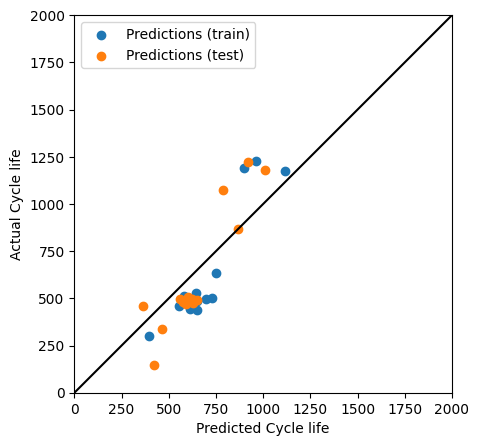

In [13]:
plot_prediction(
    discharge_model(feat_train_scaled),
    discharge_model(feat_test_scaled),
    label_train,
    label_test,
    "BaseModelPrediction"
)

In [14]:
all_rmse = pd.DataFrame(
    np.full(5, np.nan),
    index=[
        "base model (fast charge test)",
        "base model (norm charge test)",
        "transfer model",
        "traditional model",
        "base model (refined)"
    ],
    columns=["RMSE"]
)

In [15]:
all_rmse.at["base model (norm charge test)", "RMSE"] = discharge_model.evaluate(
    feat_test_scaled,
    label_test,
    verbose=0
) ** 0.5
all_rmse.at["base model (fast charge test)", "RMSE"] = discharge_model.evaluate(
    scipy.stats.zscore(fast_charge_feat[1::2]),
    fast_charge_label[1::2],
    verbose=0
) ** 0.5
all_rmse

,RMSE
base model (fast charge test),82.838534
base model (norm charge test),170.571460
transfer model,NaN
traditional model,NaN
base model (refined),NaN


## Transfer Learning

In [16]:
# Freeze model weights so only the transformer is trained
discharge_model.trainable = False

In [17]:
transfer_model = keras.models.Sequential([
    layers.Dense(units=13, kernel_initializer=keras.initializers.Identity()),
    discharge_model
])
transfer_model(feat_train_scaled)
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (15, 13)                  182       
                                                                 
 sequential (Sequential)     (None, 1)                 14        
                                                                 
Total params: 196
Trainable params: 182
Non-trainable params: 14
_________________________________________________________________


In [18]:
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error')

In [19]:
# check pre-training loss identical to base model
transfer_model.evaluate(
    feat_test_scaled,
    label_test,
    verbose=0
) ** 0.5

170.57145451027262

In [20]:
history = transfer_model.fit(
    feat_train_scaled,
    label_train,
    epochs=50,
    validation_data=(
        feat_test_scaled,
        label_test
    ),
    verbose=0
)

In [21]:
def plot_loss(history, ylims = [50, 300]):
    plt.plot(np.sqrt(history.history['loss']), label='loss')
    plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
    # plt.ylim([200, 130])
    # plt.ylim([50, 300])
    # plt.ylim([0,500])
    plt.ylim(ylims)
    plt.xlabel('Epoch')
    plt.ylabel('Error [cycles]')
    plt.legend()
    plt.grid(True)
    plt.show()

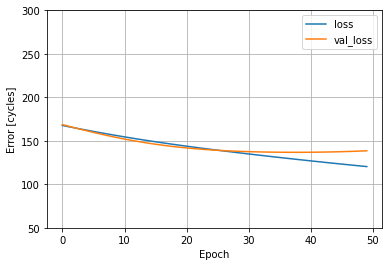

In [22]:
plot_loss(history)

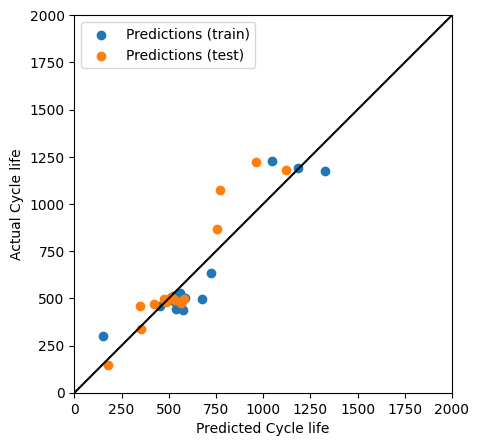

In [42]:
plot_prediction(
    transfer_model(feat_train_scaled),
    transfer_model(feat_test_scaled),
    label_train,
    label_test,
    "TransferModelPrediction"
)

In [23]:
hist = pd.DataFrame(history.history)
hist = hist.pow(0.5) # Power 1/2 is the same as square root
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
45,123.224389,137.535883,45
46,122.503520,137.746349,46
47,121.789666,137.982272,47
48,121.082782,138.242844,48
49,120.382849,138.527080,49


In [24]:
transfer_model.evaluate(
    feat_train_scaled,
    label_train, verbose=0) ** 0.5

119.68977641438303

In [25]:
# Power 1/2 is the same as square root
all_rmse.at["transfer model", "RMSE"] = transfer_model.evaluate(
    feat_test_scaled,
    label_test, verbose=0) ** 0.5
all_rmse

,RMSE
base model (fast charge test),82.838534
base model (norm charge test),170.571460
transfer model,138.527087
traditional model,NaN
base model (refined),NaN


## Try Refining Weights on Base Model
Just train the base model again on the 'normal charging' dataset and see how it's performance compares with transfer learning.

In [26]:
discharge_model.trainable = True

In [27]:
history = discharge_model.fit(
    feat_train_scaled,
    label_train,
    epochs=1000,
    validation_data=(
        feat_test_scaled,
        label_test
    ),
    verbose=0
)

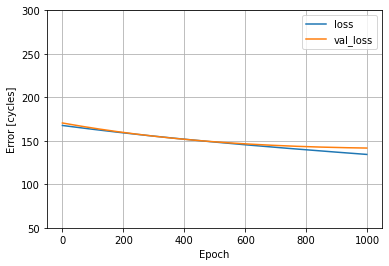

In [28]:
plot_loss(history)

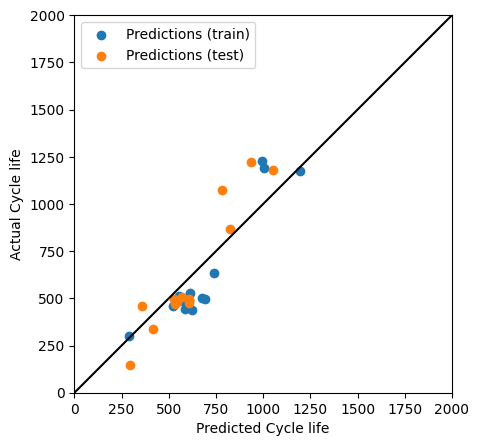

In [29]:
plot_prediction(
    discharge_model(feat_train_scaled),
    discharge_model(feat_test_scaled),
    label_train,
    label_test,
    "RefinedBaseModelPrediction"
)

In [30]:
discharge_model.evaluate(
    feat_train_scaled,
    label_train, verbose=0) ** 0.5

134.33623714164023

In [31]:
all_rmse.at["base model (refined)", "RMSE"] = discharge_model.evaluate(
    feat_test_scaled,
    label_test, verbose=0) ** 0.5
all_rmse

,RMSE
base model (fast charge test),82.838534
base model (norm charge test),170.571460
transfer model,138.527087
traditional model,NaN
base model (refined),141.691828


## Traditional Model
Model with the same structure as transfer model, trained entirely on 'normal charging' dataset without initializing with pre-learned weights.

In [32]:
traditional_stats = pd.DataFrame({
    "RMSE_train": np.zeros(10),
    "RMSE_test": np.zeros(10)
})

In [33]:
def model_iteration(n: int, stats_table: pd.DataFrame, print_summary: bool = False):
    power10 = layers.Lambda(lambda x: tf.constant(10.0)**x)
    
    discharge_model_traditional = keras.models.Sequential([
        layers.Dense(units=13,
            activation=layers.LeakyReLU(alpha=0.05),
            kernel_initializer=keras.initializers.Identity()),
        layers.Dense(units=1),
        power10
    ])
    discharge_model_traditional(feat_train_scaled)
    if print_summary:
        discharge_model_traditional.summary()
        from time import sleep
        sleep(1)
        del sleep
    
    discharge_model_traditional.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error')

    history = discharge_model_traditional.fit(
        feat_train_scaled,
        label_train,
        epochs=2500,
        validation_data=(
            feat_test_scaled,
            label_test
        ),
        verbose=0
    )
    plot_loss(history, [0, 500])

    train_score = discharge_model_traditional.evaluate(
        feat_train_scaled,
        label_train, verbose=0) ** 0.5
    
    test_score = discharge_model_traditional.evaluate(
        feat_test_scaled,
        label_test, verbose=0) ** 0.5

    stats_table.at[n, "RMSE_train"] = train_score
    stats_table.at[n, "RMSE_test"] = test_score

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (15, 13)                  182       
                                                                 
 dense_2 (Dense)             (15, 1)                   14        
                                                                 
 lambda (Lambda)             (15, 1)                   0         
                                                                 
Total params: 196
Trainable params: 196
Non-trainable params: 0
_________________________________________________________________


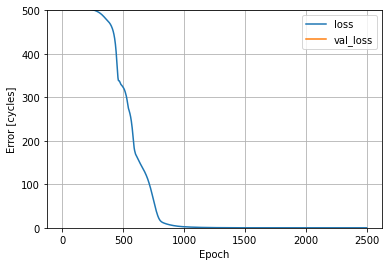

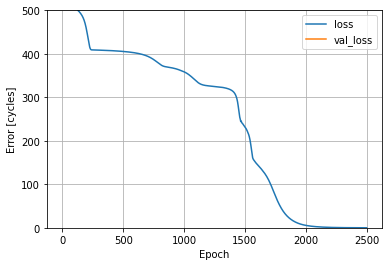

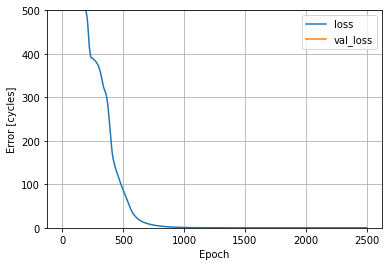

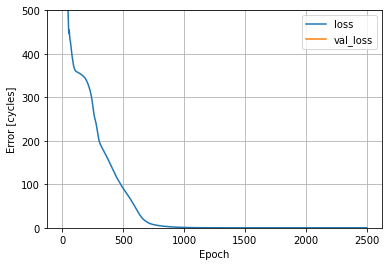

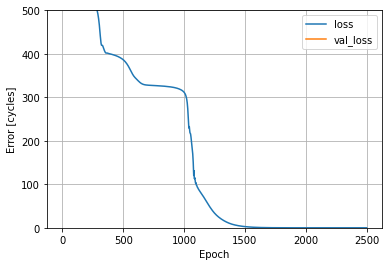

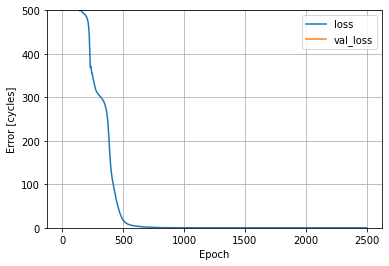

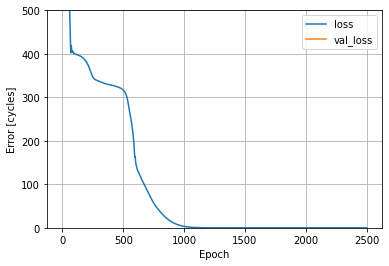

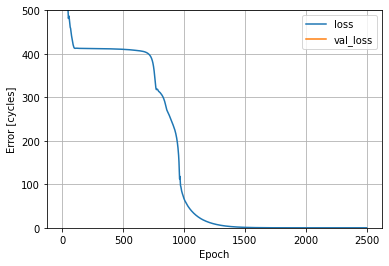

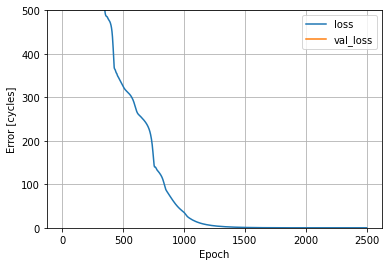

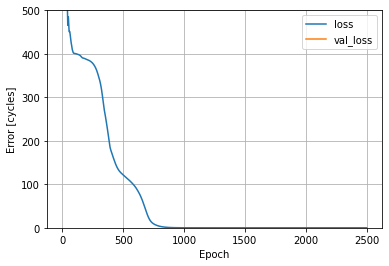

In [34]:
for i in range(10):
    model_iteration(i, traditional_stats, i == 0)

In [35]:
pd.options.display.float_format = "{:.2f}".format

In [36]:
traditional_stats.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
RMSE_train,10.00,0.01,0.02,0.00,0.00,0.00,0.00,0.05
RMSE_test,10.00,85105.74,98970.94,10251.84,20653.58,41555.99,94733.18,311005.17


In [37]:
all_rmse.at["traditional model", "RMSE"] = traditional_stats["RMSE_test"].median()
all_rmse

,RMSE
base model (fast charge test),82.84
base model (norm charge test),170.57
transfer model,138.53
traditional model,41555.99
base model (refined),141.69


## Personal Notes
Ignore code in this area

In [38]:
transfer_model.layers[0].weights[0]

<tf.Variable 'dense/kernel:0' shape=(13, 13) dtype=float32, numpy=
array([[ 1.017, -0.017,  0.017, -0.017, -0.017, -0.017,  0.017, -0.017,
        -0.017, -0.017,  0.017,  0.017,  0.   ],
       [ 0.046,  0.954,  0.046, -0.046, -0.046, -0.046,  0.046, -0.046,
        -0.046, -0.046,  0.046,  0.046,  0.   ],
       [-0.004,  0.004,  0.996,  0.004,  0.004,  0.004, -0.004,  0.004,
         0.004,  0.004, -0.004, -0.004,  0.   ],
       [-0.045,  0.045, -0.045,  1.045,  0.045,  0.045, -0.045,  0.045,
         0.045,  0.045, -0.045, -0.045,  0.   ],
       [-0.044,  0.044, -0.044,  0.044,  1.044,  0.044, -0.044,  0.044,
         0.044,  0.044, -0.044, -0.044,  0.   ],
       [-0.045,  0.045, -0.045,  0.045,  0.045,  1.045, -0.045,  0.045,
         0.045,  0.045, -0.045, -0.045,  0.   ],
       [ 0.046, -0.046,  0.046, -0.046, -0.046, -0.046,  1.046, -0.046,
        -0.046, -0.046,  0.046,  0.046,  0.   ],
       [-0.037,  0.037, -0.037,  0.037,  0.037,  0.037, -0.037,  1.037,
         0.037

In [39]:
transfer_model.layers[0].weights[1]

<tf.Variable 'dense/bias:0' shape=(13,) dtype=float32, numpy=
array([-0.049,  0.049, -0.049,  0.049,  0.049,  0.049, -0.049,  0.049,
        0.049,  0.049, -0.049, -0.049,  0.   ], dtype=float32)>

In [40]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF

# preload_feat_train = tf.constant(feat_train_scaled)
# preload_feat_test = tf.constant(feat_test_scaled)
# preload_label_train = tf.constant()
# preload_label_test = tf.constant(label_test)

batch_size = max(feat_train_scaled.shape[0], feat_test_scaled.shape[0])

preload_train_data = tf.data.Dataset.from_tensor_slices(
    (feat_train_scaled, label_train)
).with_options(options)#.batch(batch_size)

preload_test_data = tf.data.Dataset.from_tensor_slices(
    (feat_test_scaled, label_test)
).with_options(options)#.batch(batch_size)

In [41]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]